# Exploratory Data Analysis of Blood Pressure GWAS Variants
- Annotations collected via Hail in the Google Cloud Platform to then enter this EDA script
- Missingness, relationship to dependent variable, and correlation between features visualised

- Many variant annotations have missing values and so during the Hail annotation had missing values replace with zeros (to avoid imputing bias values but still using the small about of true values present in those annotations) - I am not sure about the reliability of this approach.

In [3]:
# import libraries:

import re
import time
import warnings

import matplotlib.pylab as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from pulearn import BaggingPuClassifier, ElkanotoPuClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_recall_fscore_support,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")

seed = 42

In [4]:
pd_table = pd.read_csv("BP_GWAS_data.csv")

In [6]:
features = pd_table.drop(["Gene", "CP"], axis=1)

# Visualising all annotation's distributions:

array([[<AxesSubplot:title={'center':'DANN.score'}>,
        <AxesSubplot:title={'center':'CADD.raw_score'}>,
        <AxesSubplot:title={'center':'CADD.PHRED_score'}>,
        <AxesSubplot:title={'center':'gerp_scores.N'}>,
        <AxesSubplot:title={'center':'BETAsbp'}>,
        <AxesSubplot:title={'center':'BETAdbp'}>,
        <AxesSubplot:title={'center':'BETApp'}>,
        <AxesSubplot:title={'center':'minP'}>,
        <AxesSubplot:title={'center':'motif_impact'}>],
       [<AxesSubplot:title={'center':'intergenic_impact'}>,
        <AxesSubplot:title={'center':'regulatory_impact'}>,
        <AxesSubplot:title={'center':'transcript_impact'}>,
        <AxesSubplot:title={'center':'lof_HC'}>,
        <AxesSubplot:title={'center':'polyphen_pred'}>,
        <AxesSubplot:title={'center':'sift_pred'}>,
        <AxesSubplot:title={'center':'polyphen_score'}>,
        <AxesSubplot:title={'center':'sift_score'}>,
        <AxesSubplot:title={'center':'motif_score_change'}>],
       [<AxesS

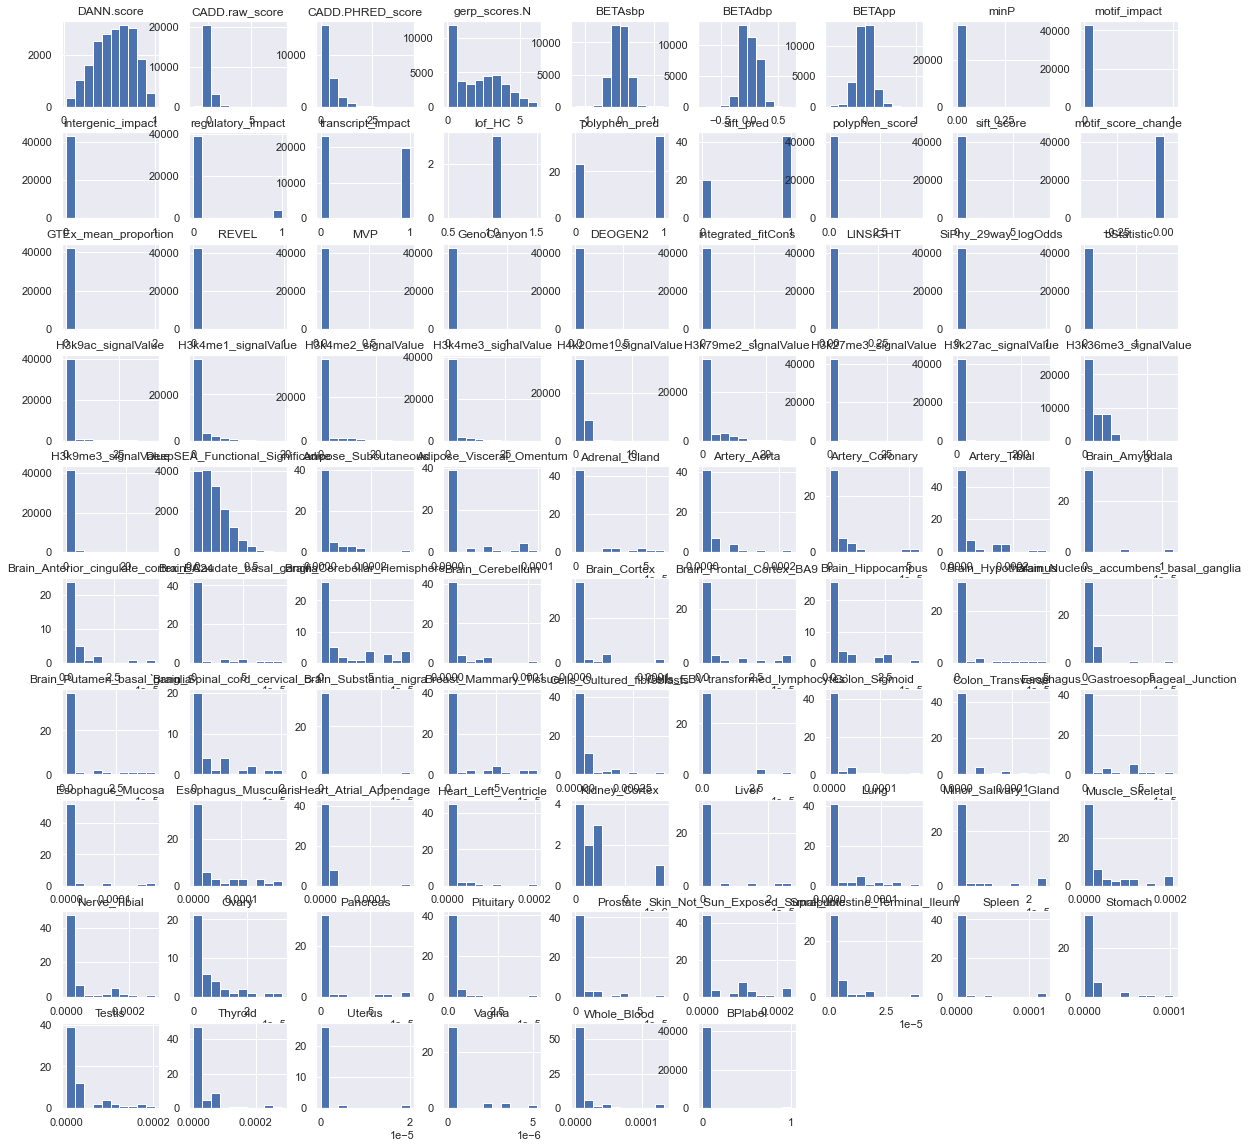

In [7]:
# Attempting to plot distributions of all variables, but I haven't been able to resize the text
sns.set(style="darkgrid")
features.hist(figsize=(20, 20))

# Exploring annotation missingness with missingno package

In [9]:
features = features.replace({0: pd.NA})

<AxesSubplot:>

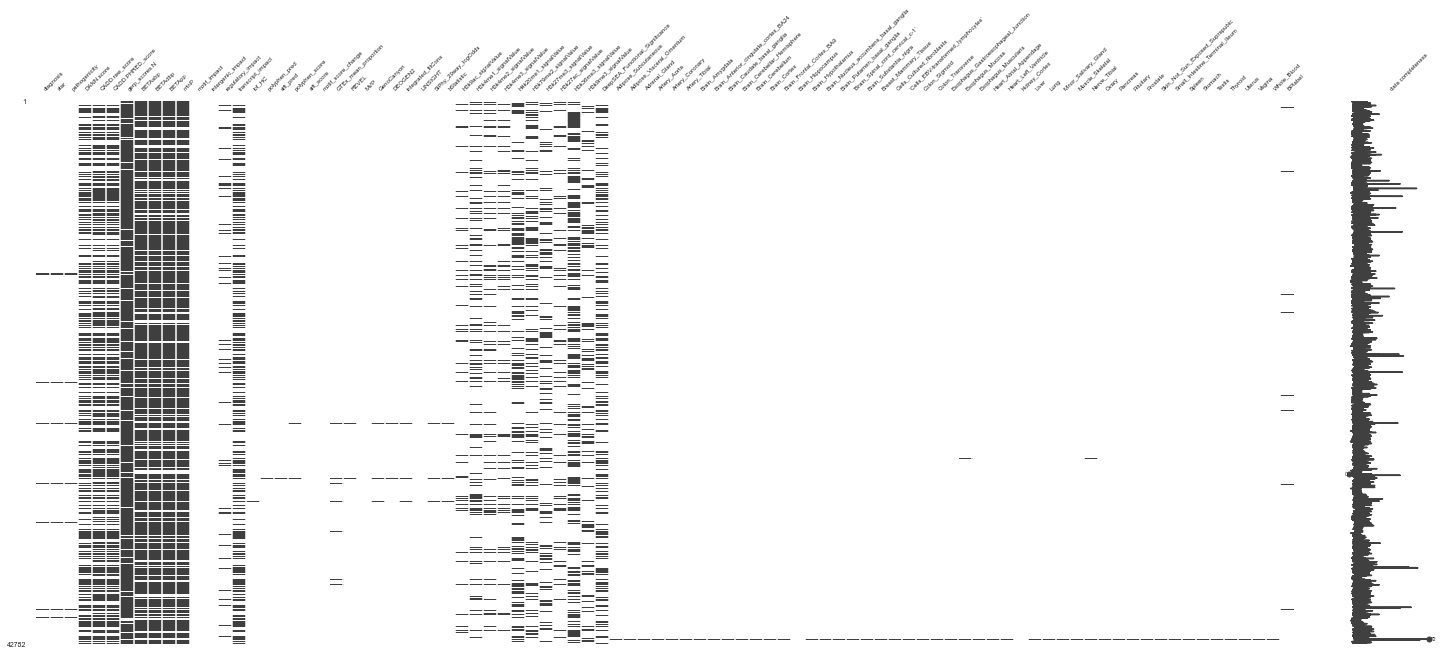

In [15]:
# Using the missingno packaging to explore missingness in the data - although this dataset is also too larger here to space it well in the notebook
# Any feature in only white is heavily missing
msno.matrix(features, labels=True, fontsize=6)

<AxesSubplot:>

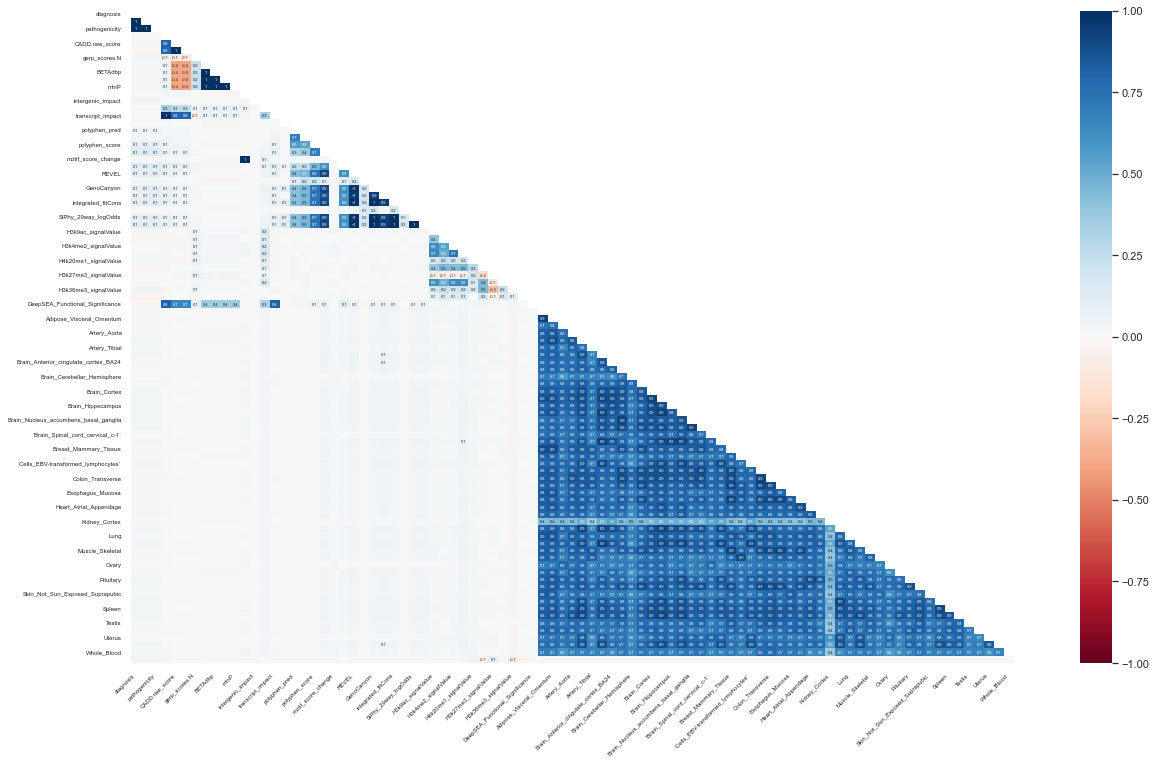

In [16]:
# Exploring how feature's missingness relates to each other - more positive values indicate that if one variable appears the other definitely also does
# Variables that are always full or always empty have no meaningful correlation
msno.heatmap(features, fontsize=6)

<AxesSubplot:>

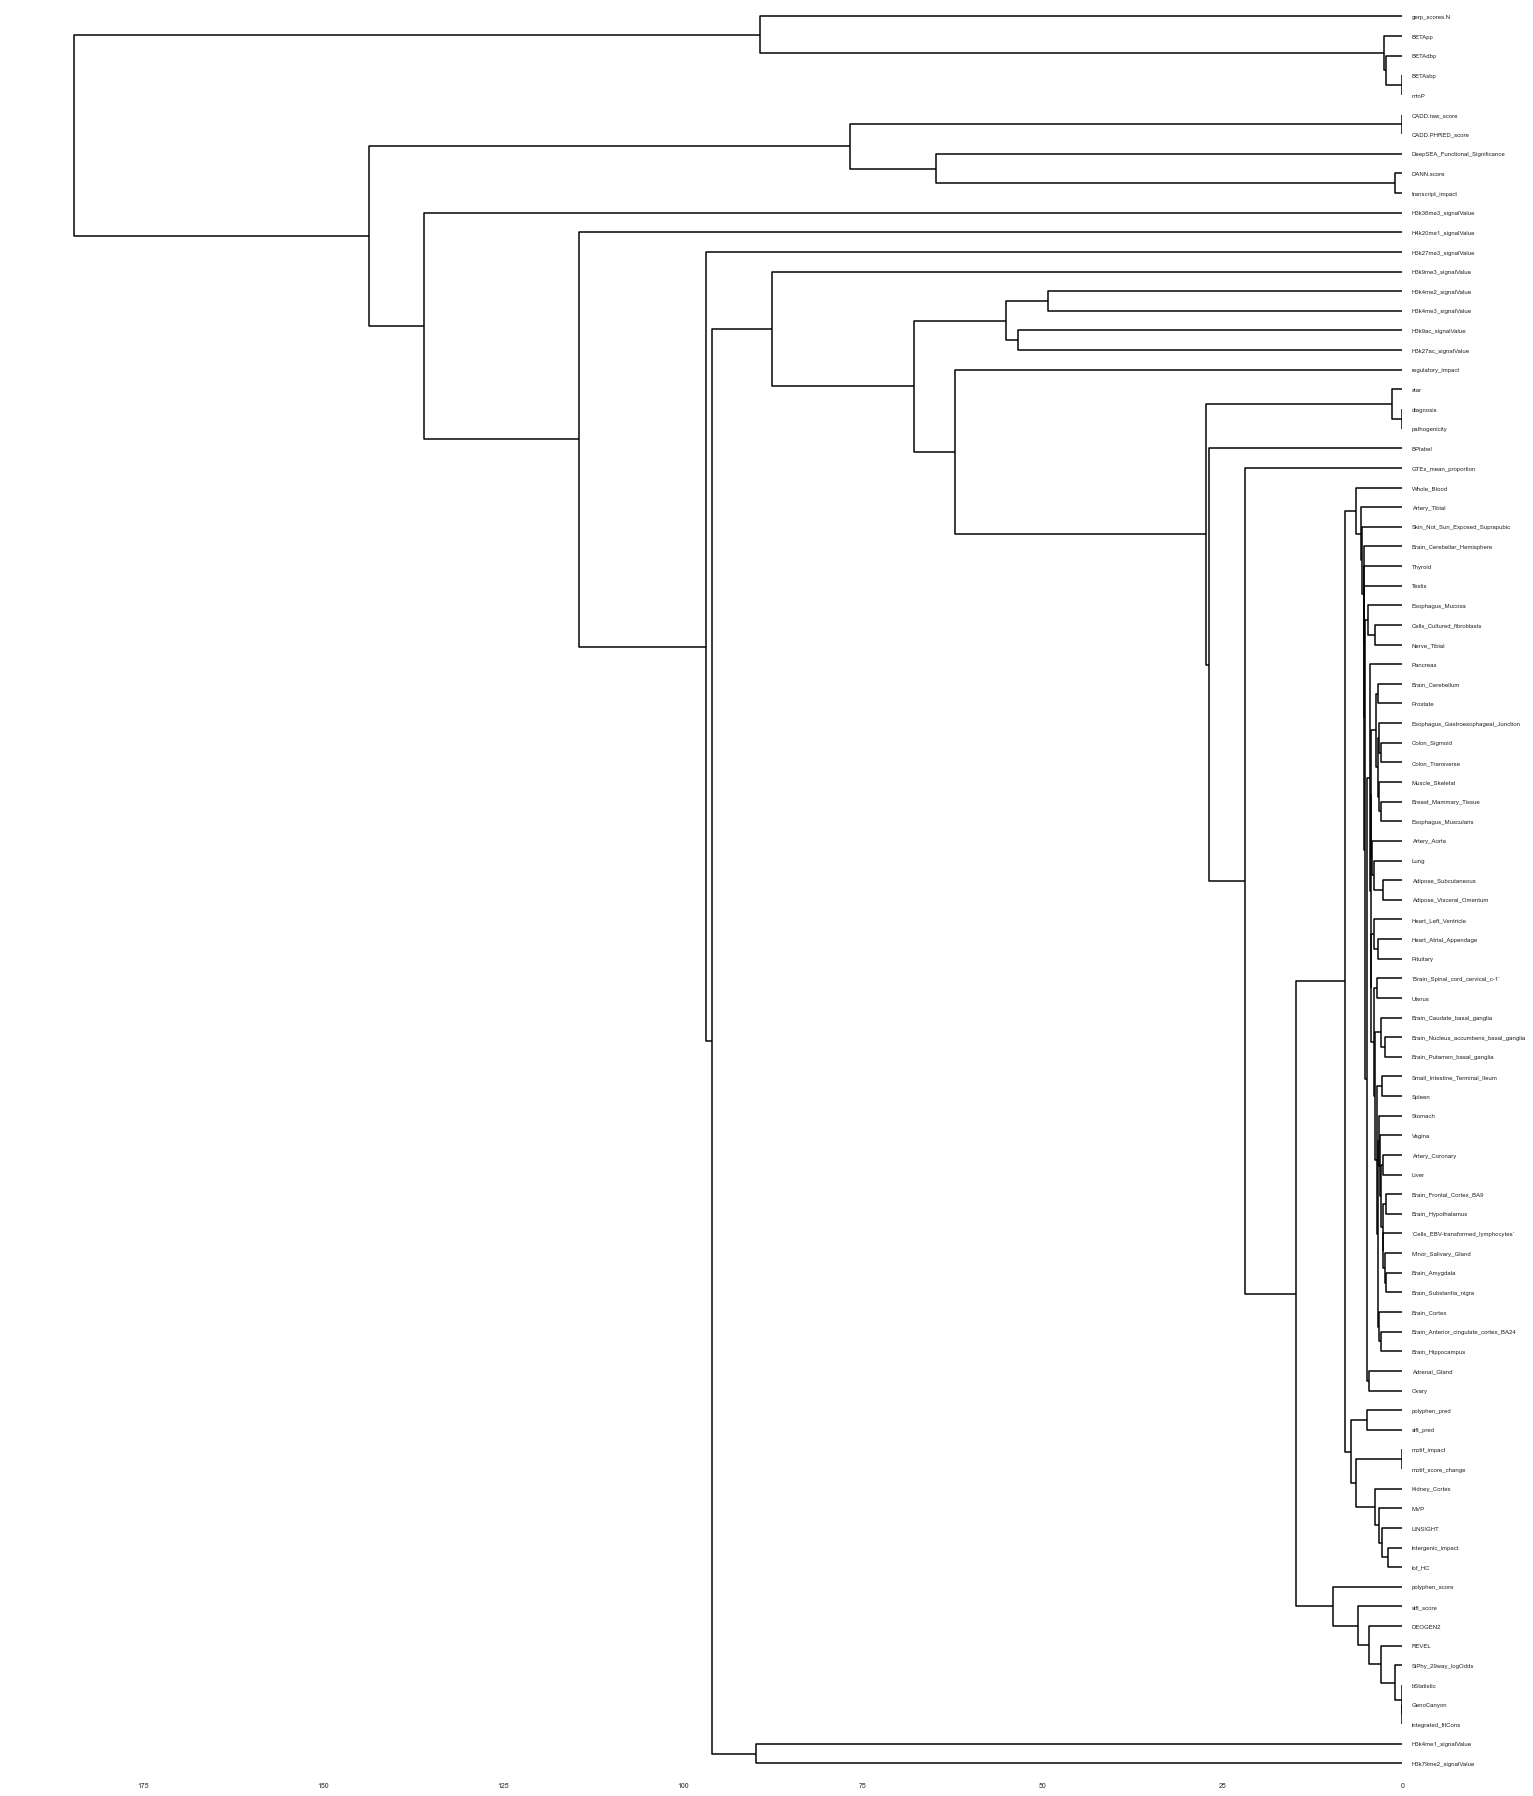

In [17]:
# Exploring trends deeper than the pairwise ones visible in the correlation heatmap
msno.dendrogram(features, fontsize=6)

<AxesSubplot:>

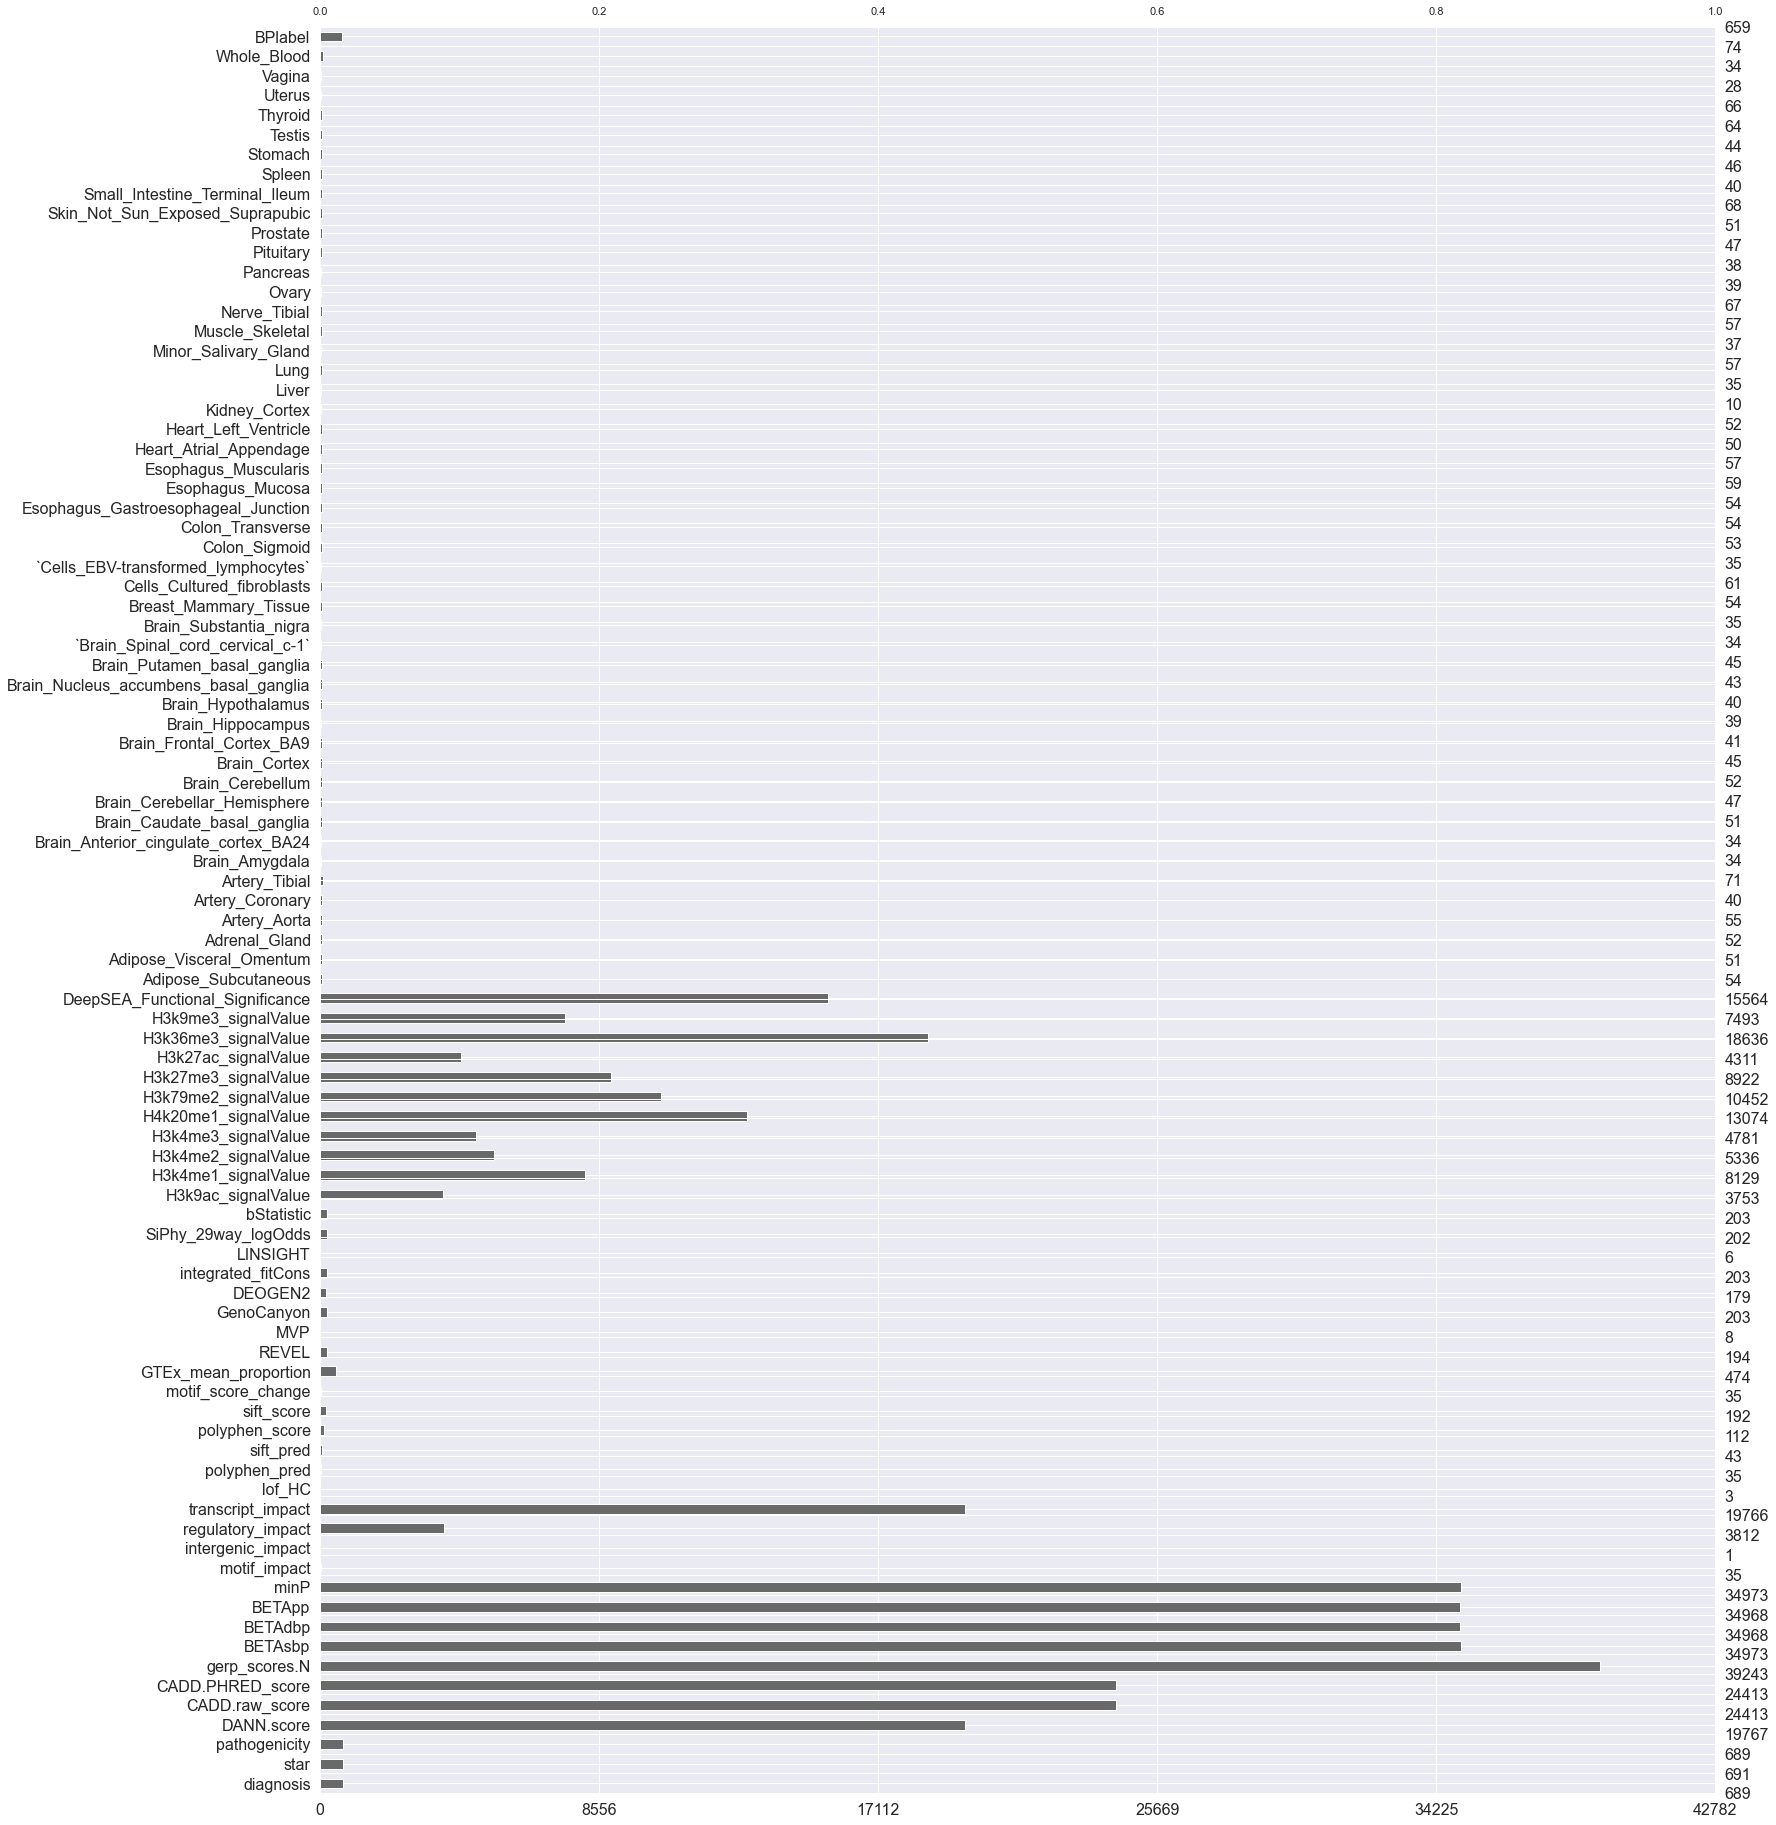

In [18]:
# Viewing overall missingness - having trouble with the axes on this one
# I think the Y axis on the right is number of rows with data, and the x axis is the variants row numbers but I think it looks more confusing than helpful
msno.bar(features)

<BarContainer object of 90 artists>

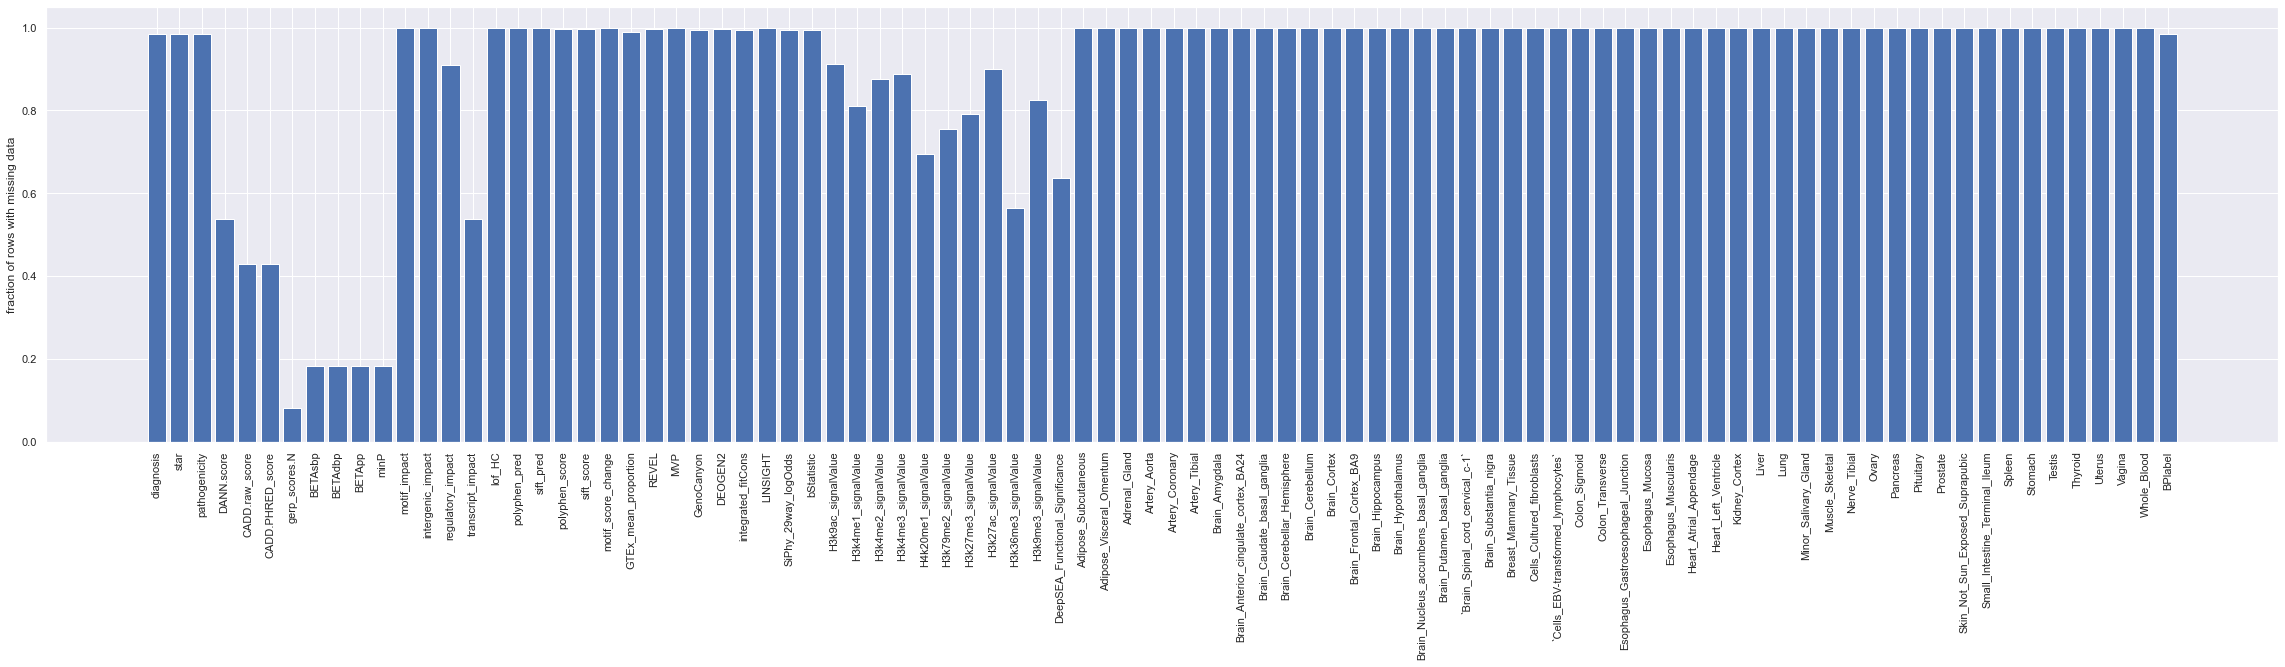

In [20]:
# Viewing overall missingness - trying a more manual version where taller bars equal higher missingess
data = features
natest = data.isnull().sum()
natest.sort_values(inplace=True)

percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_df = pd.DataFrame(
    {"column_name": data.columns, "percent_missing": percent_missing}
)
missing_value_df.sort_values("percent_missing", inplace=True)

natest = natest.to_frame()
missingdata = natest.join(missing_value_df)

null_counts = data.isnull().sum() / len(data)
plt.figure(figsize=(40, 8))
plt.xticks(
    np.arange(len(null_counts)) + 0.0, null_counts.index, rotation="vertical"
)  # when I rtry rotation=45 the text all overlaps
plt.ylabel("fraction of rows with missing data")
plt.bar(np.arange(len(null_counts)), null_counts)

# Visualising relationships between positive and 'negative' variants for each annotation

In [22]:
positives = pd_table.loc[pd_table["BPlabel"] == True]
negatives = pd_table.loc[pd_table["BPlabel"] == False]
# Sampling any group of negatives in equal quantity to positive variants - as this is what happens with each ML iteration
negatives = negatives.iloc[
    0:205,
]
pos_neg_dt = positives.append(negatives)

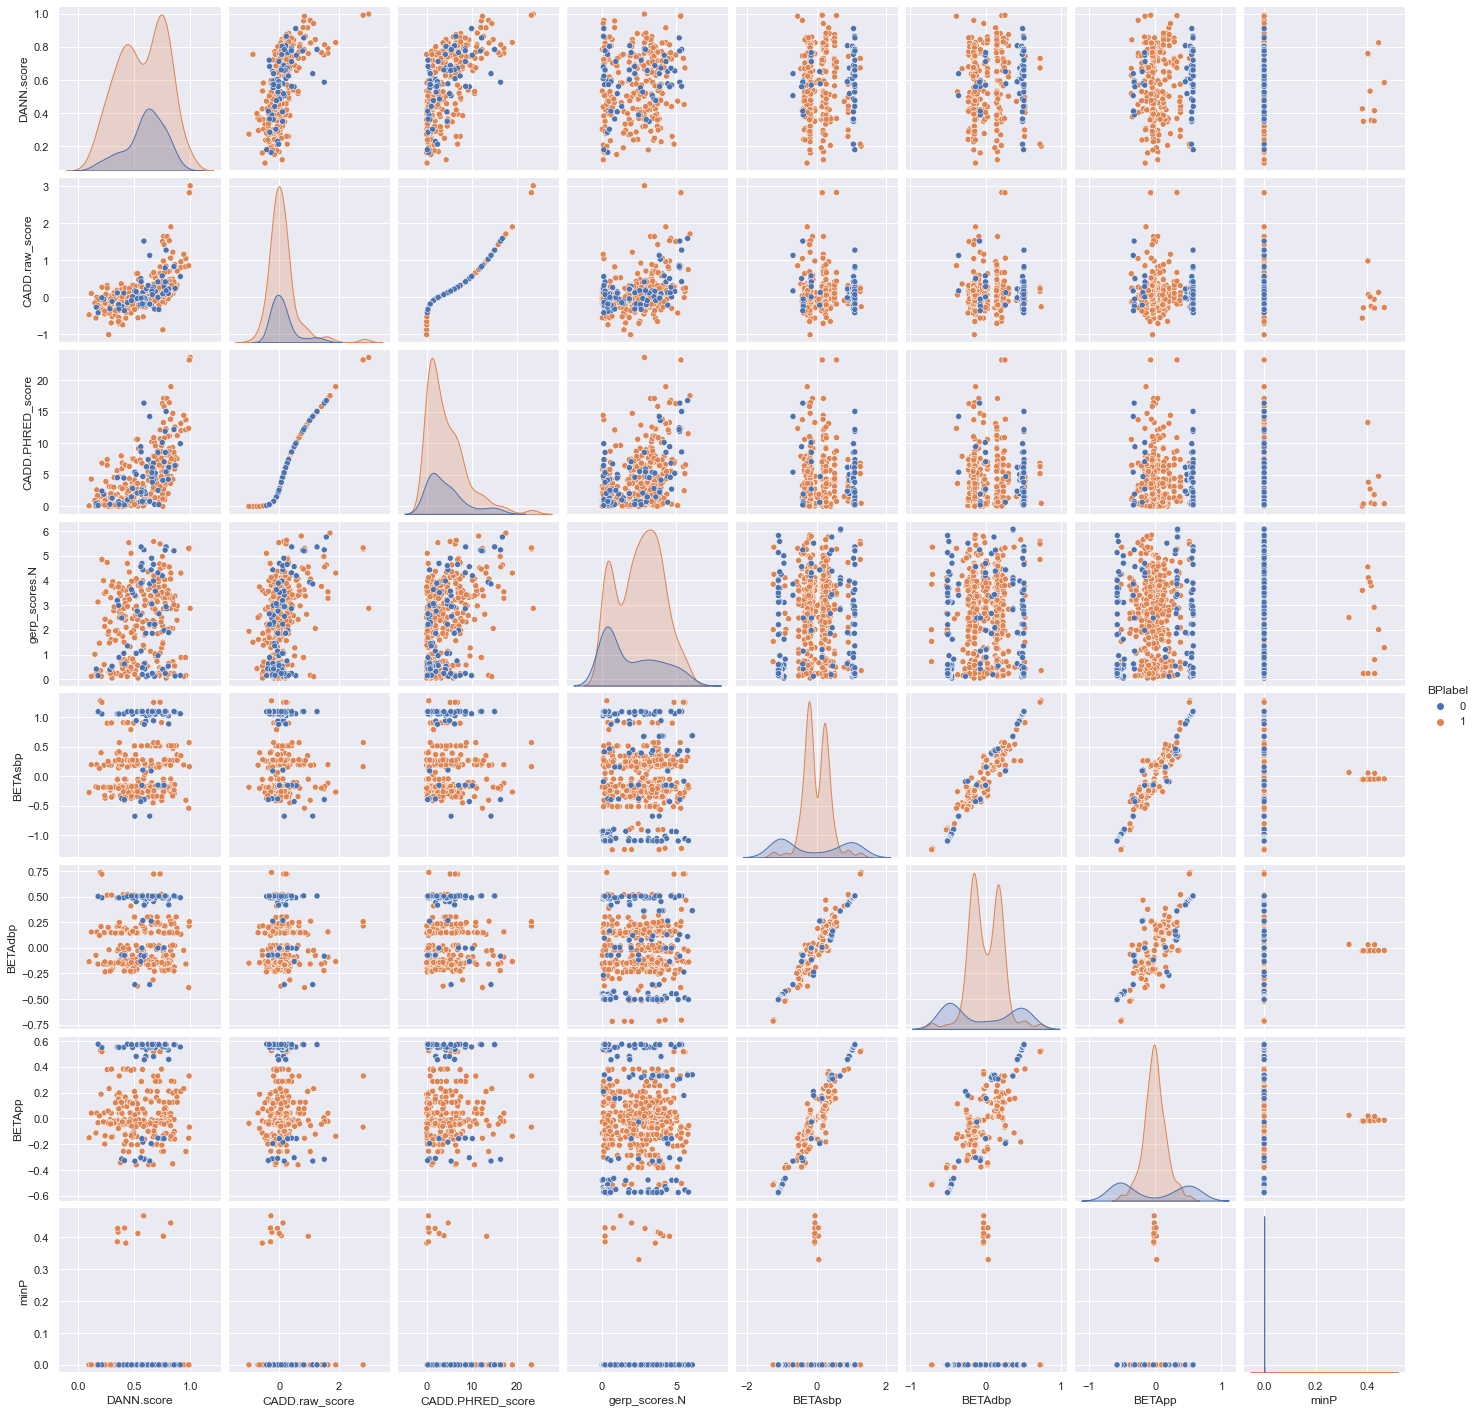

In [25]:
# Viewing pair-wise plots for the most complete/least missing features
features2 = pos_neg_dt[
    [
        "BPlabel",
        "DANN.score",
        "CADD.raw_score",
        "CADD.PHRED_score",
        "gerp_scores.N",
        "BETAsbp",
        "BETAdbp",
        "BETApp",
        "minP",
    ]
]
sns.pairplot(features2, hue="BPlabel")

In [26]:
h1 = pos_neg_dt[["BPlabel", "H3k9ac_signalValue"]]

BPlabel
1    AxesSubplot(0.125,0.125;0.775x0.755)
0    AxesSubplot(0.125,0.125;0.775x0.755)
Name: H3k9ac_signalValue, dtype: object

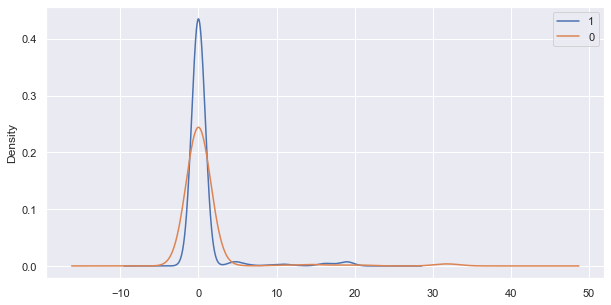

In [27]:
pos_neg_dt.groupby(pd.Grouper("BPlabel"))["H3k9ac_signalValue"].plot(
    kind="density", legend=True, figsize=(10, 5)
)

BPlabel
1    AxesSubplot(0.125,0.125;0.775x0.755)
0    AxesSubplot(0.125,0.125;0.775x0.755)
Name: H3k4me2_signalValue, dtype: object

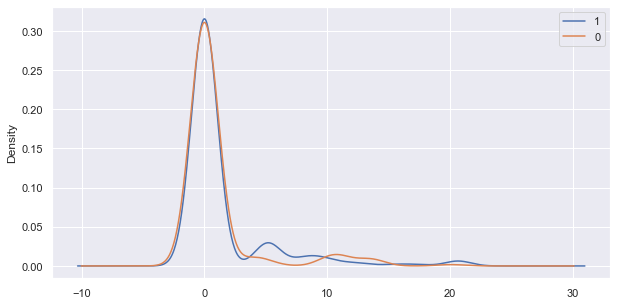

In [28]:
pos_neg_dt.groupby(pd.Grouper("BPlabel"))["H3k4me2_signalValue"].plot(
    kind="density", legend=True, figsize=(10, 5)
)

BPlabel
1    AxesSubplot(0.125,0.125;0.775x0.755)
0    AxesSubplot(0.125,0.125;0.775x0.755)
Name: H3k4me3_signalValue, dtype: object

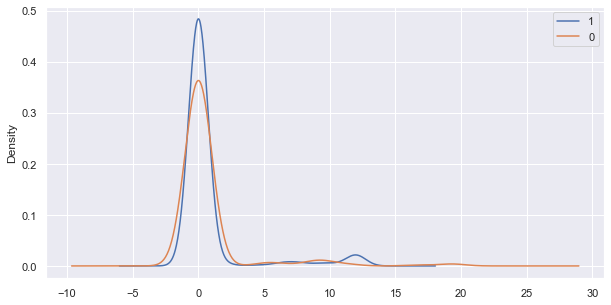

In [29]:
pos_neg_dt.groupby(pd.Grouper("BPlabel"))["H3k4me3_signalValue"].plot(
    kind="density", legend=True, figsize=(10, 5)
)

BPlabel
1    AxesSubplot(0.125,0.125;0.775x0.755)
0    AxesSubplot(0.125,0.125;0.775x0.755)
Name: H4k20me1_signalValue, dtype: object

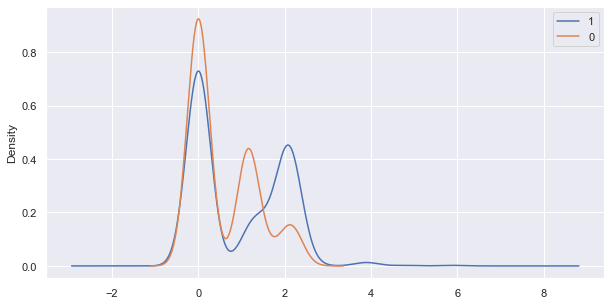

In [30]:
pos_neg_dt.groupby(pd.Grouper("BPlabel"))["H4k20me1_signalValue"].plot(
    kind="density", legend=True, figsize=(10, 5)
)

BPlabel
1    AxesSubplot(0.125,0.125;0.775x0.755)
0    AxesSubplot(0.125,0.125;0.775x0.755)
Name: H3k79me2_signalValue, dtype: object

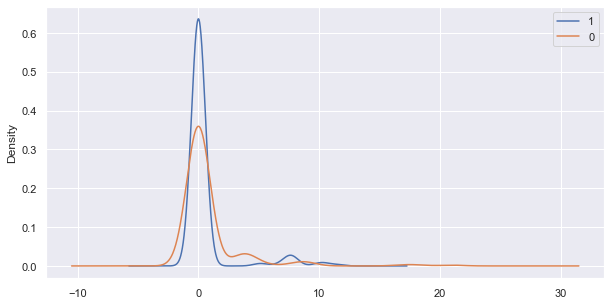

In [31]:
pos_neg_dt.groupby(pd.Grouper("BPlabel"))["H3k79me2_signalValue"].plot(
    kind="density", legend=True, figsize=(10, 5)
)

BPlabel
1    AxesSubplot(0.125,0.125;0.775x0.755)
0    AxesSubplot(0.125,0.125;0.775x0.755)
Name: H3k27me3_signalValue, dtype: object

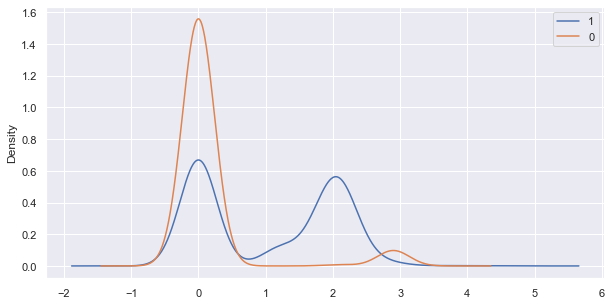

In [32]:
pos_neg_dt.groupby(pd.Grouper("BPlabel"))["H3k27me3_signalValue"].plot(
    kind="density", legend=True, figsize=(10, 5)
)

BPlabel
1    AxesSubplot(0.125,0.125;0.775x0.755)
0    AxesSubplot(0.125,0.125;0.775x0.755)
Name: H3k36me3_signalValue, dtype: object

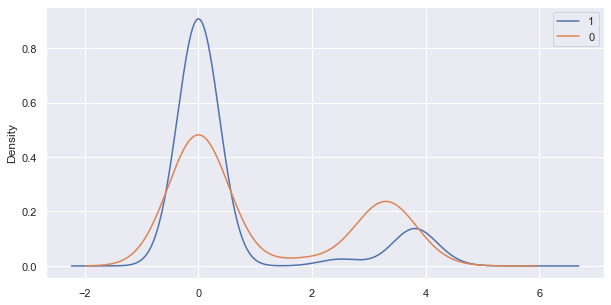

In [33]:
pos_neg_dt.groupby(pd.Grouper("BPlabel"))["H3k36me3_signalValue"].plot(
    kind="density", legend=True, figsize=(10, 5)
)

BPlabel
1    AxesSubplot(0.125,0.125;0.775x0.755)
0    AxesSubplot(0.125,0.125;0.775x0.755)
Name: H3k9me3_signalValue, dtype: object

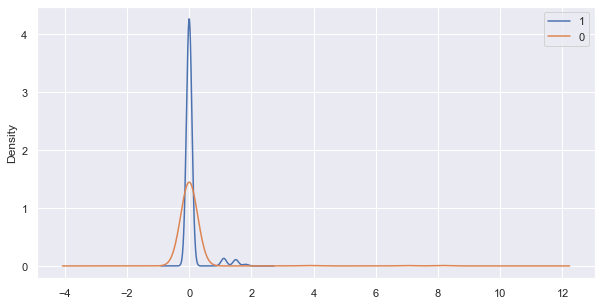

In [34]:
pos_neg_dt.groupby(pd.Grouper("BPlabel"))["H3k9me3_signalValue"].plot(
    kind="density", legend=True, figsize=(10, 5)
)

BPlabel
1    AxesSubplot(0.125,0.125;0.775x0.755)
0    AxesSubplot(0.125,0.125;0.775x0.755)
Name: DANN.score, dtype: object

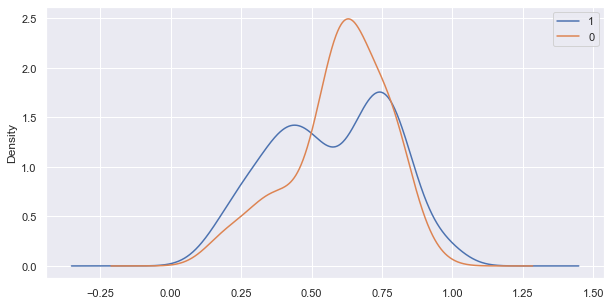

In [35]:
pos_neg_dt.groupby(pd.Grouper("BPlabel"))["DANN.score"].plot(
    kind="density", legend=True, figsize=(10, 5)
)

BPlabel
1    AxesSubplot(0.125,0.125;0.775x0.755)
0    AxesSubplot(0.125,0.125;0.775x0.755)
Name: CADD.raw_score, dtype: object

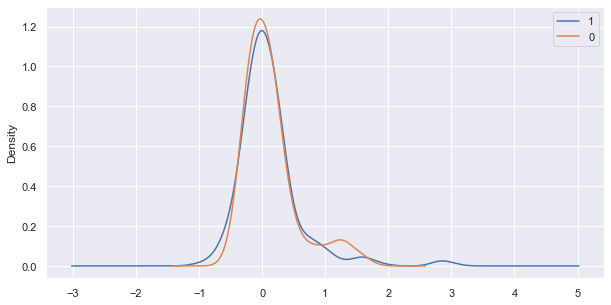

In [36]:
pos_neg_dt.groupby(pd.Grouper("BPlabel"))["CADD.raw_score"].plot(
    kind="density", legend=True, figsize=(10, 5)
)

BPlabel
1    AxesSubplot(0.125,0.125;0.775x0.755)
0    AxesSubplot(0.125,0.125;0.775x0.755)
Name: CADD.PHRED_score, dtype: object

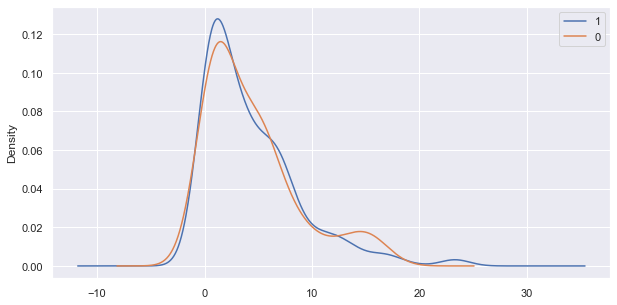

In [37]:
pos_neg_dt.groupby(pd.Grouper("BPlabel"))["CADD.PHRED_score"].plot(
    kind="density", legend=True, figsize=(10, 5)
)

BPlabel
1    AxesSubplot(0.125,0.125;0.775x0.755)
0    AxesSubplot(0.125,0.125;0.775x0.755)
Name: gerp_scores.N, dtype: object

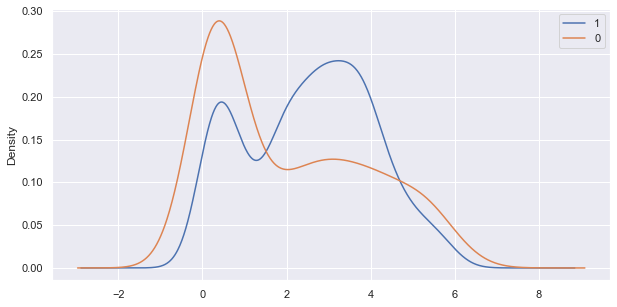

In [38]:
pos_neg_dt.groupby(pd.Grouper("BPlabel"))["gerp_scores.N"].plot(
    kind="density", legend=True, figsize=(10, 5)
)

BPlabel
1    AxesSubplot(0.125,0.125;0.775x0.755)
0    AxesSubplot(0.125,0.125;0.775x0.755)
Name: BETAsbp, dtype: object

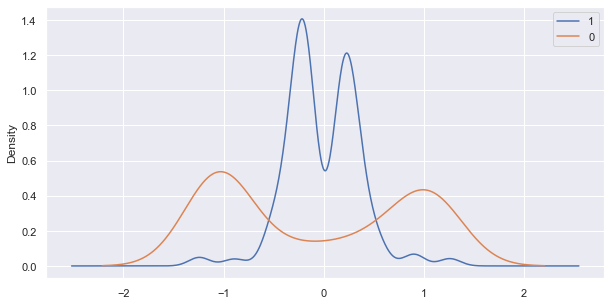

In [39]:
pos_neg_dt.groupby(pd.Grouper("BPlabel"))["BETAsbp"].plot(
    kind="density", legend=True, figsize=(10, 5)
)

BPlabel
1    AxesSubplot(0.125,0.125;0.775x0.755)
0    AxesSubplot(0.125,0.125;0.775x0.755)
Name: minP, dtype: object

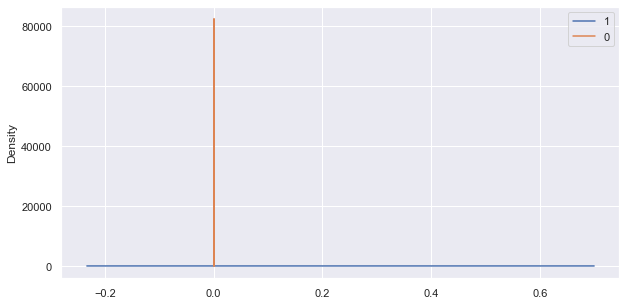

In [40]:
pos_neg_dt.groupby(pd.Grouper("BPlabel"))["minP"].plot(
    kind="density", legend=True, figsize=(10, 5)
)

In [35]:
# pos_neg_dt['Pvalue_log10']= np.log10(pos_neg_dt['Pvalue'])
# pos_neg_dt.groupby(pd.Grouper('label'))['Pvalue_log10'].plot(kind='density', legend=True, figsize=(10,5))

Text(0.5, 0.98, 'DANN.score')

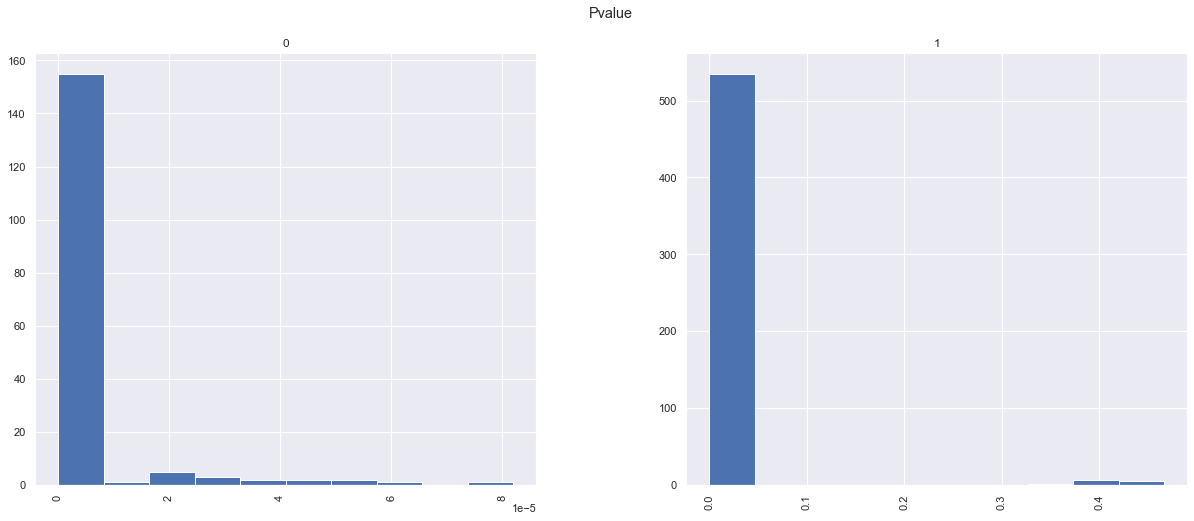

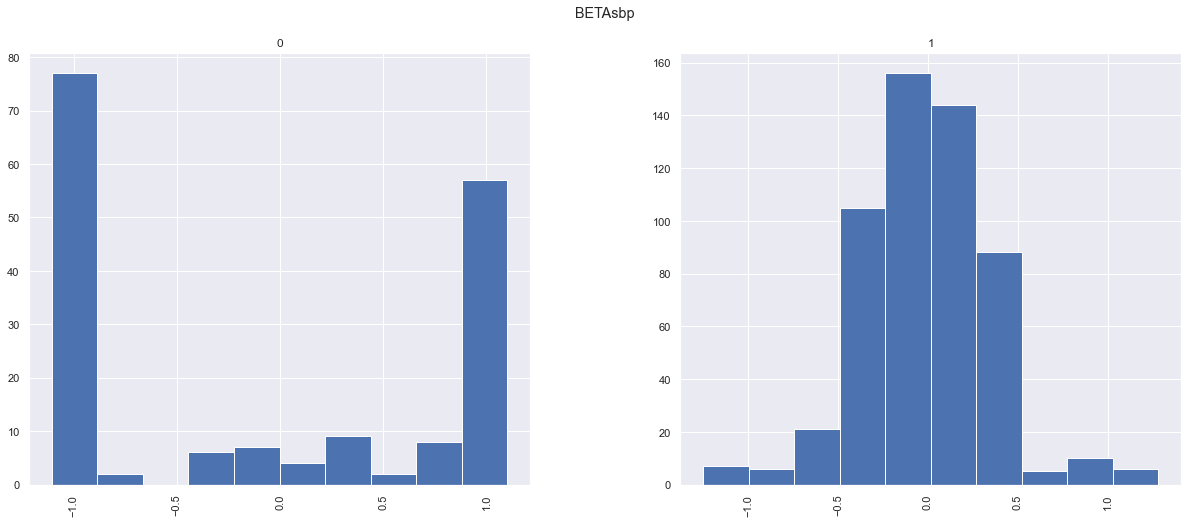

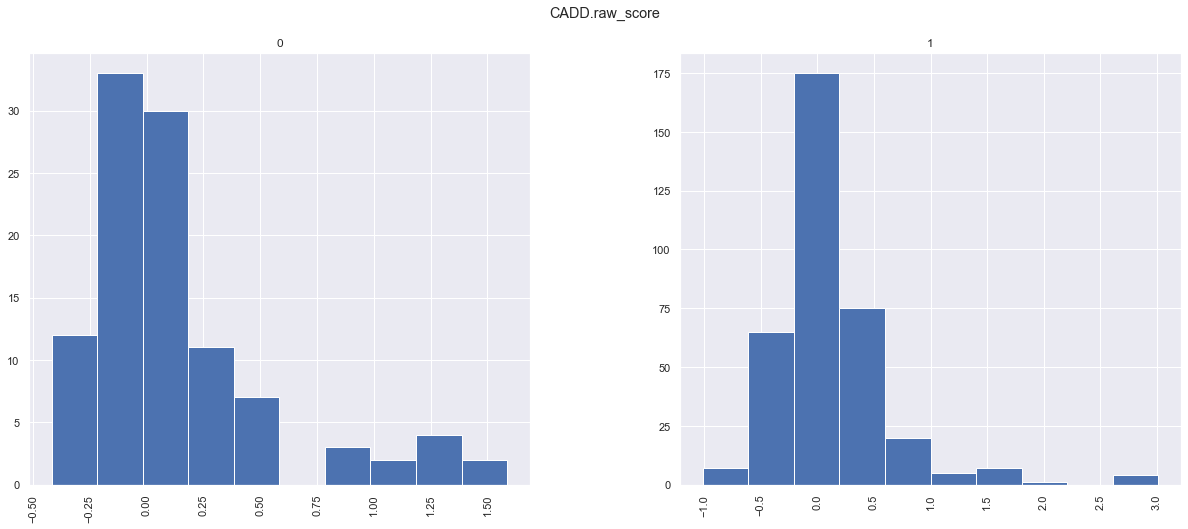

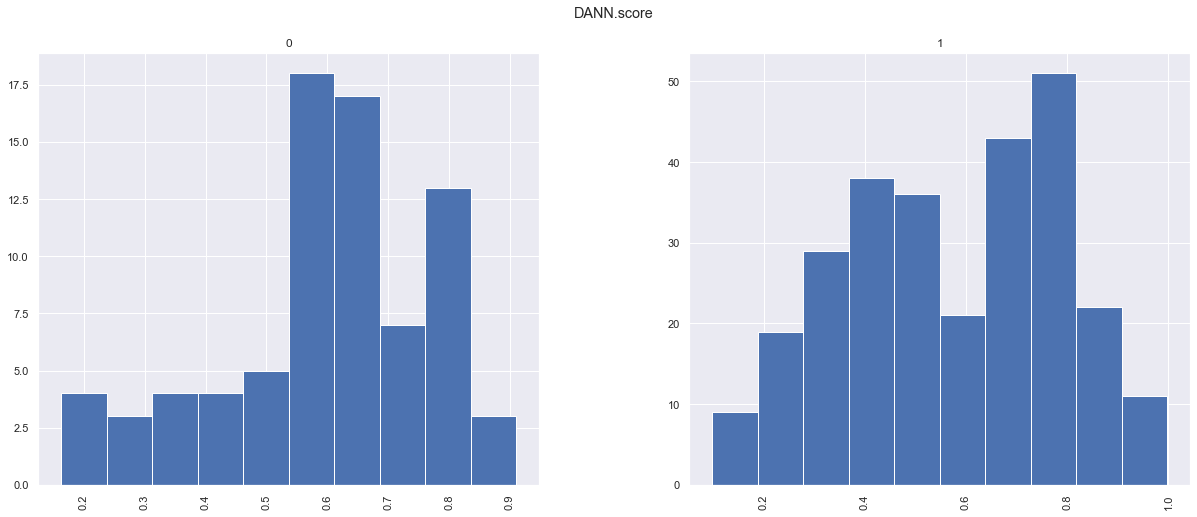

In [42]:
# Histograms of annotations for 'negative' ('False') variants vs positive (True) variants
sns.set(style="darkgrid")
pos_neg_dt["minP"].hist(by=pos_neg_dt["BPlabel"], figsize=(20, 8))
plt.suptitle("Pvalue")
pos_neg_dt["BETAsbp"].hist(by=pos_neg_dt["BPlabel"], figsize=(20, 8))
plt.suptitle("BETAsbp")
pos_neg_dt["CADD.raw_score"].hist(by=pos_neg_dt["BPlabel"], figsize=(20, 8))
plt.suptitle("CADD.raw_score")
pos_neg_dt["DANN.score"].hist(by=pos_neg_dt["BPlabel"], figsize=(20, 8))
plt.suptitle("DANN.score")

# Visualising correlated features

In [50]:
features = pd_table.drop(["Gene", "CP", "BPlabel"], axis=1)
features["BPlabel"] = np.where(pd_table["BPlabel"] == True, 1, 0)
correlated_features = set()
correlation_matrix = features.corr()

# identifying highly correlated features to remove before machine learning
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [51]:
print(correlated_features)

{'Heart_Atrial_Appendage', 'sift_pred', 'Pituitary', 'SiPhy_29way_logOdds', 'Minor_Salivary_Gland', 'Whole_Blood', 'Brain_Caudate_basal_ganglia', 'bStatistic', 'Kidney_Cortex', 'BETApp', 'Brain_Substantia_nigra', 'Vagina', 'CADD.PHRED_score', 'Brain_Anterior_cingulate_cortex_BA24', 'integrated_fitCons', 'Small_Intestine_Terminal_Ileum', 'Spleen', 'Muscle_Skeletal', 'Uterus'}


BPlabel                 1.000000
polyphen_pred           0.153197
sift_pred               0.123490
minP                    0.110255
H3k27me3_signalValue    0.081497
                          ...   
Stomach                      NaN
Testis                       NaN
Thyroid                      NaN
Uterus                       NaN
Vagina                       NaN
Name: BPlabel, Length: 87, dtype: float64


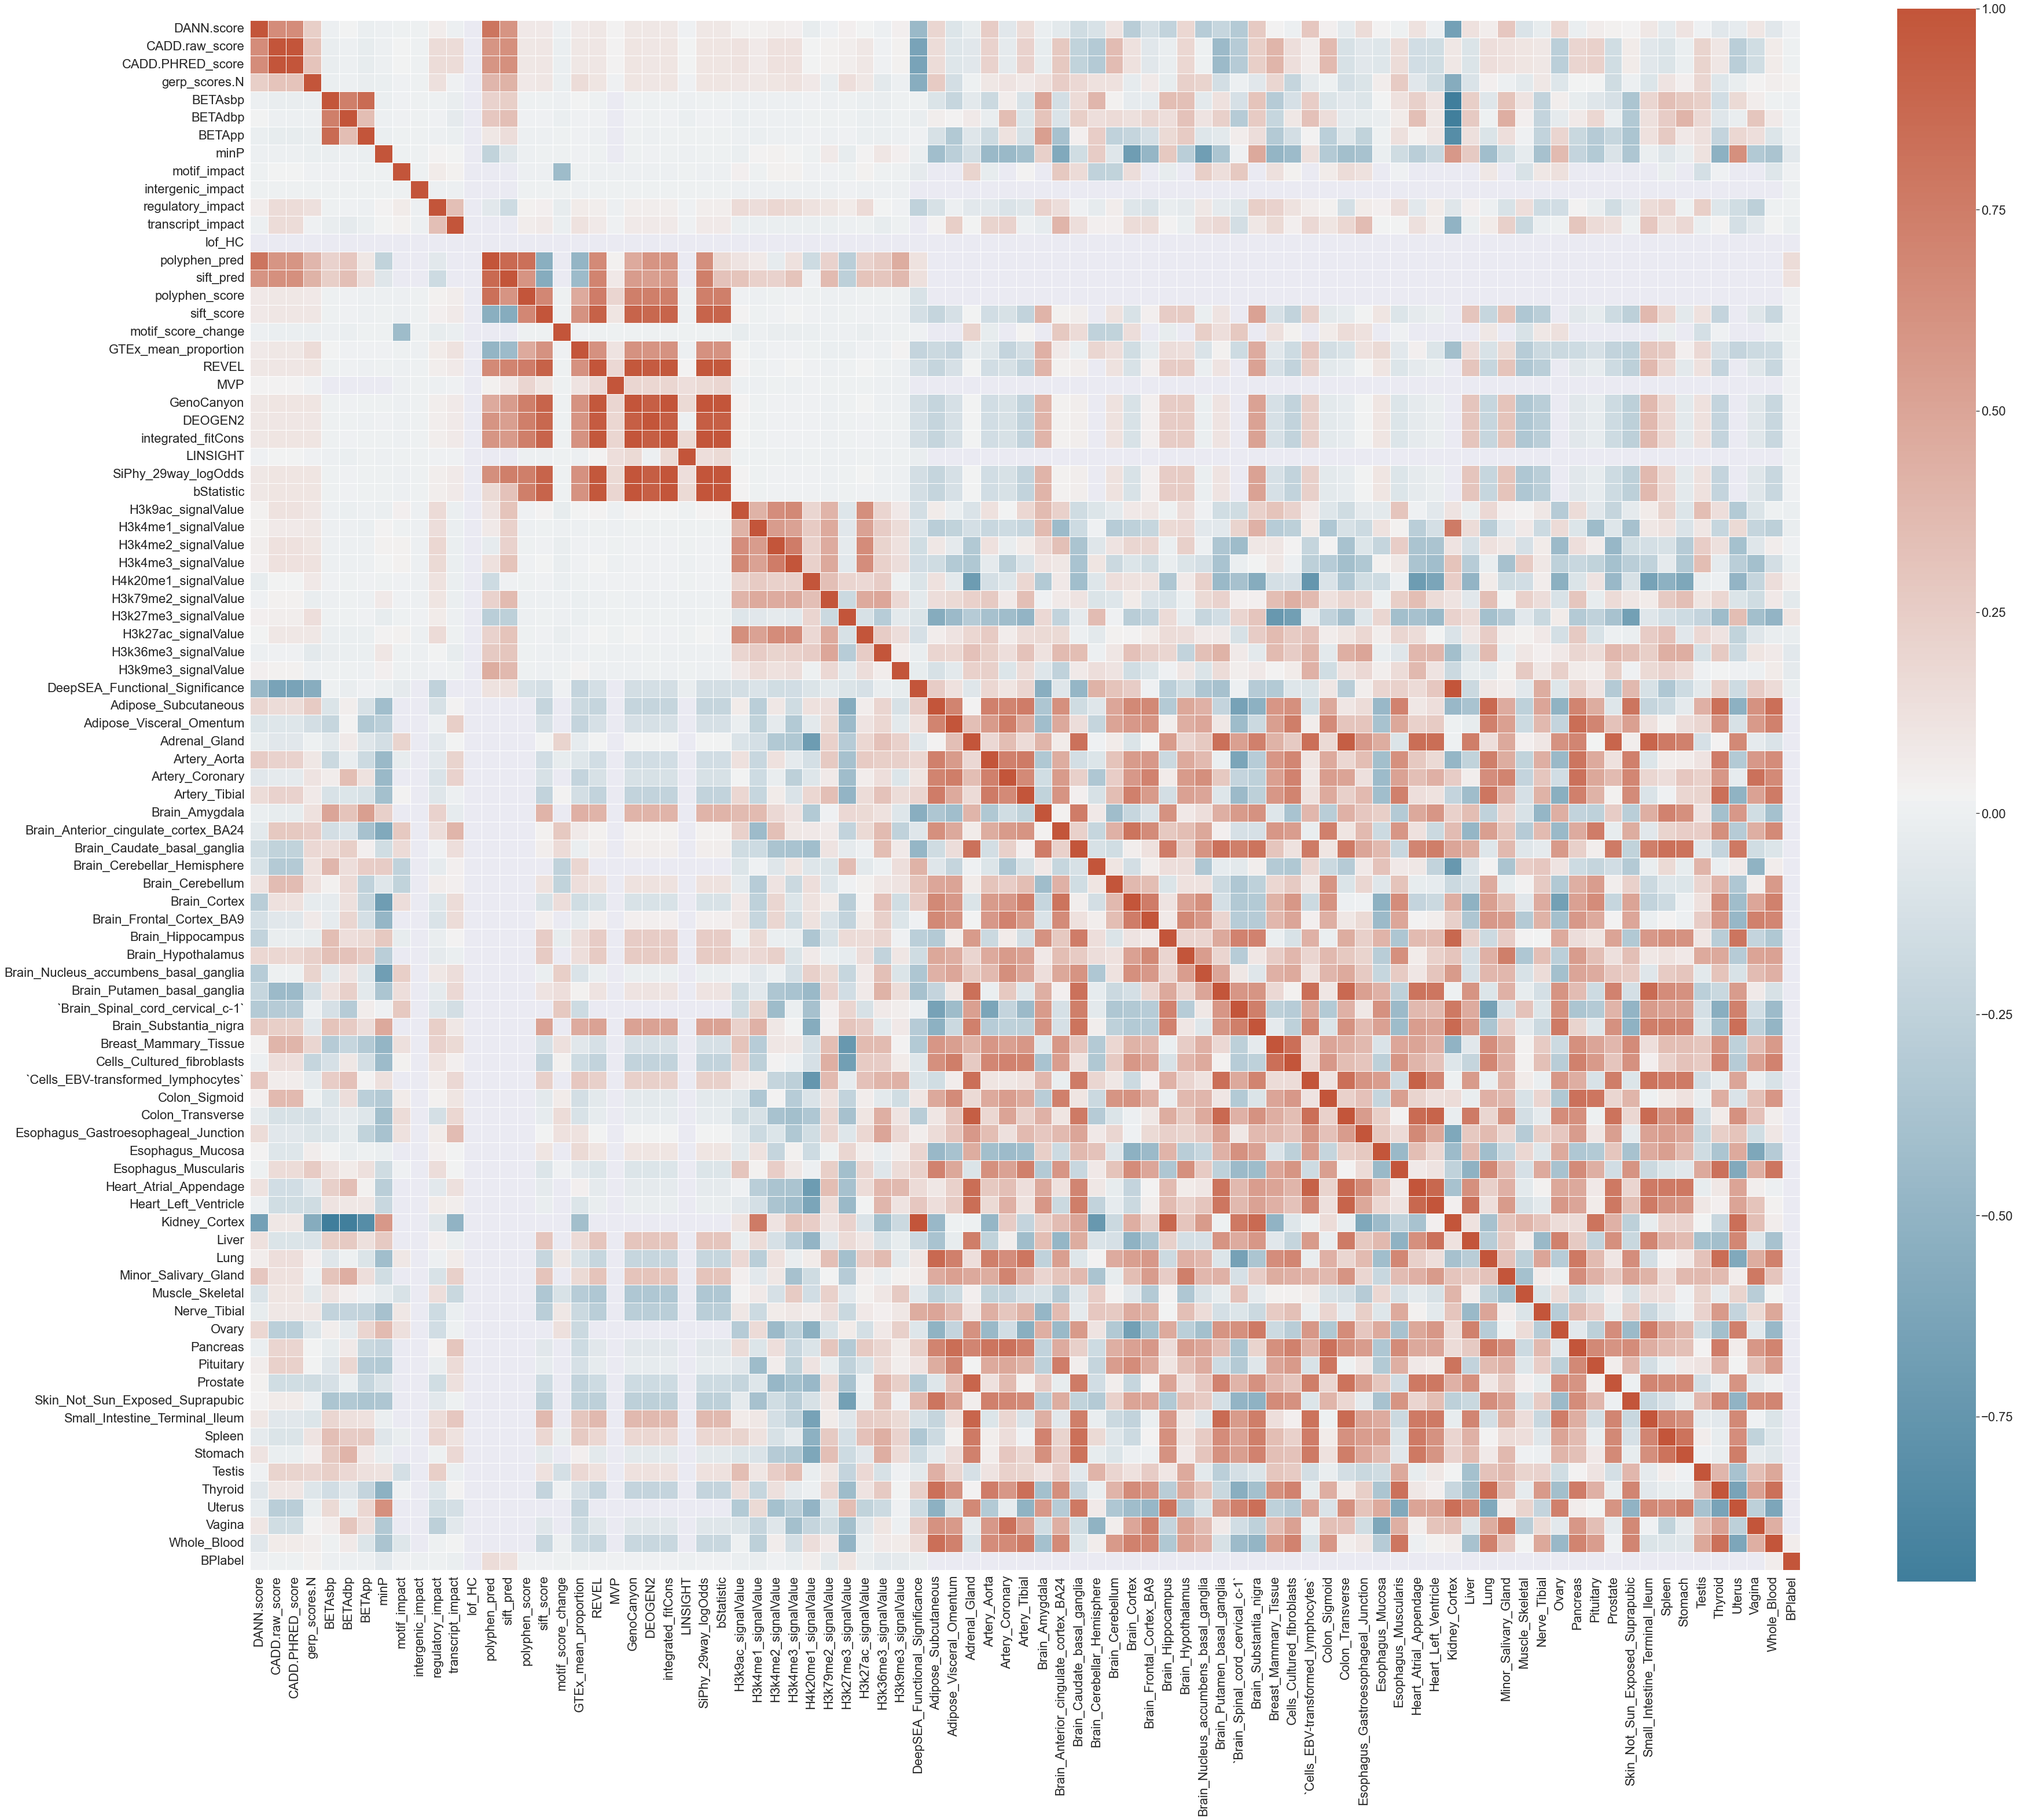

In [52]:
corr = features.corr(method="spearman")

f, ax = plt.subplots(figsize=(60, 50))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.set(font_scale=2)
sns.heatmap(
    corr,
    cmap=cmap,
    square=True,
    xticklabels=True,
    yticklabels=True,
    linewidths=0.5,
    ax=ax,
)

corr_matrix = features.corr()
print(corr_matrix["BPlabel"].sort_values(ascending=False))
corr = corr_matrix["BPlabel"].sort_values(ascending=False)